In [1]:
#!pip install -r requirements_training.txt

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Random Forest
>**Random forest classifier è un algoritmo di classificazione che genera alberi decisionali casuali e splitta il dataset in tanti samples da dare in pasto a questi alberi (in modo tale da evitare l'overfitting).**

>**L'algoritmo inoltre salva tutte le accuracy che vengono prodotte da questi alberi e restituisce una media di esse come accuracy finale dell' algoritmo**


>>**Nella mia implementazione dell' algoritmo, assegno un n_estimator dinamico tra 1 a 100 (ho controllato se un numero superiore a 100 mi potesse aiutare , ma non è stato cosi :) ) il numero di stimatori mi dice a ogni iterazione quanti alberi casuali genera e di quanti ne fà la media**


In [3]:
model = { 'Knn'  : KNeighborsClassifier() , 'DT' : DecisionTreeClassifier(criterion= 'entropy'), 'RF': RandomForestClassifier(), 'LR': LogisticRegression(penalty= 'l2',max_iter = 1000) }

In [4]:
accuracy = { 'Knn'  : 0, 'DT' : 0, 'RF': 0, 'LR': 0 }

In [5]:
n_features_lasso =0

In [6]:
def X_y(dataset,target):
        y= dataset[target]
        X= dataset.drop([target],axis=1)
        return X,y

In [7]:
def load_data(csv):
    dataset=pd.read_csv(csv)
    return dataset

In [8]:
def chiavi(dataset):
    for i in dataset:
        print ("La colonna :",i,"ha le chiavi",dataset[i].unique())

## Features selection 
> Eseguo un features selection provando  una Regolarizzazione di tipo l1 'Lasso' che mi abbate i pesi con un fattore di regolarizzazione da aggiungere alla **funzione di costo**
>> $$R(\boldsymbol{w}) = \sum_l \left | w_l \right |$$

> esso mi abbatte i pesi **w** usando una discesa del gradiente che penalizza in modulo i pesi (che si vanno a sommare alla **funzion. di costo**, e  quindi dando lo stesso equilibrio sia ai pesi grandi che ai pesi piccoli nella fase di training di minimizzazione della funzione.

>Inoltre sperimento un abbattimento dei pesi anche servendomi di una Ridge regression la quale ha un fattore di regolarizzazione di tipo **l2 norm**  che abbatte i valori dei pesi piu grandi(ne fà il quadrato e li aggiunge alla Loss) piuttosto che quelli piccoli ( quelli tra 0 e 1 vengono rimpiccioliti con il quadrato) sempre usando una discesa del gradiente e facendo la somma di tutti i pesi del vettore **W**
>> $$R(\boldsymbol{w}) = \sum_l  w_l^2 $$

>Il costo della ridge con aggiunta del fattore di regolazione **l2 norm** può essere riassunta come segue

>> $$  CostoRidge(w) = RSS (w) +\lambda R(w)$$

>Il costo dell ridge ( o possiamo chiamarla anche **Loss Function** ) non è nient' altro che il costo della funzione di costo , che nell' esempio è la RSS sommato a un **lambda** più questo fattore di regolarizzazione.
Il coeff. **lambda** è un coefficiente di smorzamento o tuning e va a fare appunto tuning dei parametri dando sterzate più o meno forti a ogni iterazione nell' aggiornamento dei pesi nella discesa del gradiente.

>**La Ridge è molto più efficente anche con pochi campioni di training e riduce l' overfitting**

>Uso per fare tutto ciò un meta_trasformatore chiamto SelectFromModel a cui serve uno stimatore passatogli come parametro per restituire con il metodo .get_support() una lista di booleani che mi corrispondono alle features da scegliere oppure no

In [9]:
def features_selection(X,y,X_test,alpha):
    #Ridge= Ridge(alpha =0.01,random_state = 0,max_iter =100).fit(X,y)
    #selector = SelectFromModel(Ridge, prefit =True) 

    
    selector = SelectFromModel(Lasso(max_iter = 1000, alpha = alpha,random_state = 0))
    selector.fit(X,y)
    
    return X[X.columns[selector.get_support()]],X_test[X_test.columns[selector.get_support()]]

**Faccio 50 iterazioni aumentando gli estimatori del RandomClassifier a ogni iterazione**

In [10]:
def RF_iter(X_train,X_test,y_train,y_test,disegna):
    accuracy_RF = []
    for i in range(1,10):
        forest = RandomForestClassifier(n_estimators = i, random_state = 0)
        forest.fit(X_train,y_train)
        accuracy_RF.append(forest.score(X_test,y_test))
   
    if(disegna ==1):
        plt.plot(np.arange(1,len(accuracy_RF)+1),accuracy_RF,label ='Random Forest' )
    
    max_accuracy = np.max(accuracy_RF)
    max_index = 0
    for j in range(0,len(accuracy_RF)):
    
        if(accuracy_RF[j]== max_accuracy):
            max_index=j+1
            if(disegna==1):
                print ("L'accuracy massima del random forest è con :",max_index, "estimatori")
                print ("L'accuracy massima del random forestè :",max_accuracy,"\n")
            return max_accuracy,RandomForestClassifier(n_estimators = max_index , random_state = 0)
   
   

**Faccio 500 iterazioni aumentando la profondità dell' albero ad ognuna**

In [11]:
def DT_iter (X_train,X_test,y_train,y_test,disegna):
    accuracy_DT = []
    for i in range(1,10):
        tree = DecisionTreeClassifier(criterion= 'entropy',max_depth = i+2, random_state = 0)
        tree.fit(X_train,y_train)
        accuracy_DT.append(tree.score(X_test,y_test))
    
    if(disegna ==1):
        plt.plot(np.arange(1,len(accuracy_DT)+1),accuracy_DT,label = 'DecisionTreeclassifier')
    
    max_accuracy_DT = np.max(accuracy_DT)
    max_index_DT = 0
    for j in range(0,len(accuracy_DT)):
    
          if(accuracy_DT[j]== max_accuracy_DT):
            max_index_DT=j+3
            if(disegna==1):
                print ("L'accuracy massima del DT è con profondità :",max_index_DT)
                print ("L'accuracy massima del DT è :",max_accuracy_DT)
            return max_accuracy_DT, DecisionTreeClassifier(criterion= 'entropy',max_depth = max_index_DT, random_state = 0)
   

**Salvo le accuracy dei vari modelli migliori trovati nelle precedenti elaborazioni**

In [12]:
def model_evaluation(X_train,X_test,y_train,y_test,disegna):
    for i in model.keys():
        if(i == 'RF'):
            
            max_accuracy,modello_RF = RF_iter(X_train,X_test,y_train,y_test,disegna)
            model[i] = modello_RF
            accuracy[i]= max_accuracy
           
        elif(i == 'DT'):
            accuratezza, modello_DT = DT_iter(X_train,X_test,y_train,y_test,disegna)
          
            model[i] = modello_DT
            
            
            accuracy[i]=accuratezza
           
        else:
            modello = model[i]
           
            modello.fit(X_train,y_train)
            if(disegna == 1):
                print("per ",i,"l'accuratezza è",modello.score(X_test,y_test))
            accuracy[i]=modello.score(X_test,y_test)

In [13]:
def modello_con_maggiore_accuracy():
    accuracy_finale =(max(list(accuracy.values())))
    for i in accuracy.keys():
        if(accuracy.get(i)== accuracy_finale):
            modello_finale = i
            return accuracy_finale,(model.get(modello_finale)),modello_finale

In [14]:
def da_plottare(modello,X_train,y_train,X_test,y_test,title):
    labels = [' no', ' yes']
    modello.fit(X_train,y_train)
    plot_confusion_matrix(modello, X_test, y_test,normalize='all',  cmap=plt.cm.YlGn,display_labels=labels ) #, normalize='false'
    plt.title(title)
    plt.show()

In [15]:
def visualizza(dataset):
     for i in dataset:
        print("colonna :",i,"conta", dataset[i].nunique(),"valori di chiavi diversi")
    

In [16]:
def con_senza_fselection(X_train,y_train,X_test,y_test):
    disegna = 0
    lista_acc = []
    lista_alpha = [0.001,0.01]
    for i in lista_alpha:
        
        X_new_train,X_new_test = features_selection(X_train,y_train,X_test,i)
        if ((X_new_train.shape[0]!= 0)&(X_new_test.shape[0]!= 0)):
            model_evaluation(X_new_train, X_new_test, y_train, y_test,disegna)
            accuracy_end_new,modello_new,titolo_new = modello_con_maggiore_accuracy()
            print("Numero colonne usate all iterazione di alpha = :",i,"è:", len(X_new_test.columns)," e l'accuracy è :",accuracy_end_new)
            lista_acc.append(accuracy_end_new)
    
    
    max_acc_lasso = max(lista_acc)
    
    
    model_evaluation(X_train, X_test, y_train, y_test,disegna)
    accuracy_end,modello,titolo = modello_con_maggiore_accuracy()
    print("L'accuracy massima senza fselection è :",accuracy_end," e il numero colonne di X_train è",len(X_train.columns))
    if(max_acc_lasso >= accuracy_end):
       
        for j in range(0,len(lista_acc)):
          
            if(lista_acc[j]==max_acc_lasso):
                
                max_alpha_lasso = lista_alpha[j]
        print("E' STATA  SCELTA LA FSELECTION DI TIPO LASSO CON ALPHA :",max_alpha_lasso)
        X_train,X_test = features_selection(X_train,y_train,X_test,max_alpha_lasso)
       
        disegna = 1
        print("Numero colonne usate nel finale :", X_train.columns.to_list())
        model_evaluation(X_train, X_test, y_train, y_test,disegna)
        accuracy_end,modello,titolo = modello_con_maggiore_accuracy()
        return accuracy_end,modello,titolo,X_train,X_test
    else:
        print("NON E STATA SCELTA LA FSELECTION ")
        
        disegna = 1
        model_evaluation(X_train, X_test, y_train, y_test,disegna)
        accuracy_end,modello,titolo = modello_con_maggiore_accuracy()
        return accuracy_end,modello,titolo,X_train,X_test
    
    
    
    
        

In [17]:
def load_file(): 
    Train = load_data('train.csv')
    Test = load_data('test.csv')
    return Train,Test

In [18]:
def X_train_y_train(target):  
    y_train = Train[target]
    X_train = Train.drop(columns = target)
  
    return X_train,y_train

In [19]:
def X_test_y_test(target): 
    y_test = Test[target]
    X_test = Test.drop(columns = target)
   
    return  X_test,y_test


**Elaboro il dataset e sostituisco una lista di caratteri spuri con NaN a cui poi posso interagire semplicemente**

In [20]:
def elabora_dataset_e_pulisci(dataset):
    spuri = ['?','#','@',',','.',' ']
    
    
    for i in dataset.columns:
        for j in spuri: 
            if( j in dataset[i].to_list()):
                dataset[i]=dataset[i].replace(j,np.NaN)
            
   
  

**Cancello le colonne che hanno una numerosità di valori come quella degli elementi del dataset poichè non danno alcuna informazione a livello di previsione**

In [21]:
def colonne_id(dataset):
    
    for i in dataset:
       
        
        if((dataset[i].nunique() == dataset.index.size)):#sara un id o comunque non serve
            dataset = dataset.drop(columns=[i])
       
    return dataset

## Binning
>**Applico una tecnica di Binning a determinate colonne trovate con determinate proporzioni.  Questa tecnica, mi crea un intervallo invece di avere un numero float64 o int64 nudo e crudo, credo che avere un intervallo sia più descrittivo durante il processo di previsione di un pattern predittivo**



>**Ho deciso di divedere in massimo 5 intervalli sul massimo delle colonne del valore del train**

In [22]:
def Binning(dataset,col, max_valore_col_train): #la Uso per Age , per Scheduled_giorno
    lista = []
    if(dataset[col].dtypes in ['int64','float64']):
        
        
        for j in range(dataset[col].shape[0]):
            
            if(dataset[col].loc[j] <= int((1/5)*max_valore_col_train)):
                lista.append(0)
                

            elif( (dataset[col].loc[j] > int((1/5)*max_valore_col_train)) & (dataset[col].loc[j] <= int((2/5)*max_valore_col_train)) ):
                lista.append(1)

            elif((dataset[col].loc[j] > int((2/5)*max_valore_col_train)) & (dataset[col].loc[j] <= int((3/5)*max_valore_col_train))):
                lista.append(2)

            elif((dataset[col].loc[j] > int((3/5)*max_valore_col_train)) & (dataset[col].loc[j] <= int((4/5)*max_valore_col_train))):
                lista.append(3)

            elif(dataset[col].loc[j] > int((4/5)*max_valore_col_train)):
                lista.append(4)
    
    dataset["_"+ col +"_interval"] = pd.DataFrame(lista)
    dataset = dataset.drop(columns = col) 
    return dataset

## RIMOZIONE DEI VALORI NULL O IMPUTAZIONE
>>**Scelgo di rimuovere i valori null dalla tabella o farne imputazione a seconda della numerosità di questi valori, se il numero di valori nulli non supera 1/100 esimo del numero di dati , ne faccio imputazione , altrimenti eseguo una cancellazione delle righe con quei valori**

>>**Faccio ciò perchè reputo che fare un imputazione su un numero elevato di datapoint sostituendo i valori nulli con la media o il termine più frequente, mi comprometterebbe un inquinamento del dataset, compromettendo l' analisi dell pattern che l'algoritmo cerca di prevedere.**
## Imputazione
>>**L' imputazione è un processo di sotituzione di valori nulli all' interno di un dataset. In particolare esso si basa sulla sostituzione di valori numerici tramite valore medio della stessa features e sostituzione di valori categorici tramite il valore più frequente sempre della stessa features. Ci sono molti altri modi di sostituze .**

>>**Mi servo della classe SimpleImputer a cui passo come parametro la strategia con cui fare imputazione.**


In [23]:
n_imputer= SimpleImputer(strategy = 'mean')
c_imputer = SimpleImputer(strategy = 'most_frequent')

In [24]:
def rimuovi_null_o_imputazione_train(dataset):
    categorical_features_column= pd.DataFrame()
    numerical_features_column= pd.DataFrame()
   
    for i in dataset:
        
        if(dataset[i].isnull().sum() >0):
           
            if(dataset[i].isnull().sum() >= ((1/100)*dataset.index.size)):
                print("HO RIMOSSO LE RIGHE DELLA COLONNA",i,"DEL DATASET")
                dataset = dataset.dropna(subset=[i])
                dataset = dataset.reset_index()[dataset.columns]
               
            else:
                print("HO FATTO IMPUTAZIONE SU " ,i,"DEL DATASET")
                #colonna categorica
                if(dataset[i].dtypes == object ):
                    categorical_features_column = dataset[i]
                else:
                    numerical_features_column = dataset[i]
                    # print(categorical_features.columns)
                    # print(numerical_features.columns)
               

                if(categorical_features_column.empty == False):
                    categorical_features_2 = pd.DataFrame(c_imputer.fit_transform(pd.DataFrame(categorical_features_column)))
                   
                    categorical_features_2.rename_axis(i)
                    dataset[i]= categorical_features_2

                else:
                    numerical_features_2 = pd.DataFrame(n_imputer.fit_transform(pd.DataFrame(numerical_features_column)))
                    
                    numerical_features_2.rename_axis(i)
                    dataset[i]= numerical_features_2
    return dataset        
               

## Encoding dei dati
>**Uso labelEncoder() che mi trasforma tutte le features categoriche in numeriche assegnando i numeri R positivi (da 0 a più infinito) a ogni valore categorico o ( intervallo del Binning) assegnando in ordine alphanumerico**

In [25]:
encoder = LabelEncoder()

In [26]:
def encoding(dataset):
    
    for i in dataset:
        encoder.fit(dataset[i])
        dataset[i]= encoder.transform(dataset[i])
    return dataset

**Faccio il fit sul train e poi trasformo il test con il fit del train**

In [27]:
def encoding_prova(Train,Test,encoder):
    print(encoder)
    for i in Train:
        if(Train[i].dtypes == 'object'):
            print (i)
            encoder.fit(Train[i])
        
            Train[i]=encoder.transform(Train[i])
            Test[i]=encoder.transform(Test[i])
    return Train,Test

**Faccio la stessa pila trasformativa avuta nel train per l 'altro notebook( lì è presente una spiegazione dei metodi usati). Essa mi servirà per trasformare il test**

In [28]:
def cancella_colonne(Train,Test):
    for col in Test.columns:
       
        if(Test[col].name not in Train.columns.to_list()):
            
            Test=Test.drop(columns = col)
    return Test

In [29]:
def concat_dataset(Train,Test):
    data = pd.concat([Train,Test],axis=0)
    data.reset_index()[data.columns]
    #data = pipeline(data)
    data = encoding(data)
   
    return data

In [30]:
def lav_dataset(data,righe_train):
    train_percent = int((80*data.shape[0])/100)
   
    print("Train Percent",train_percent)
    
    Train = data.iloc[:righe_train-1]
    Test = data.iloc[righe_train:]
    return Train,Test

In [31]:
def pipeline(dataset,val_Age,val_attesa,val_Scheduled,val_Appo):
    elabora_dataset_e_pulisci(dataset)
  
    dataset = rimuovi_null_o_imputazione_train(dataset)#facendolo prima sul train e poi sul test, esso si addestra sul test

     
    dataset = colonne_id(dataset)
    
    
    dataset = Binning(dataset,'Age',val_Age)
    print(dataset.info())
    dataset = Binning(dataset,'attesa_giorni',val_attesa)
    #dataset = Binning_qc(dataset,'Scheduled_ora_precisa',3)
    dataset = Binning(dataset,'Scheduled_giorno',val_Scheduled)
    dataset = Binning(dataset,'Appointment_giorno',val_Appo)
    #dataset = Binning_qcut(dataset,'Scheduled_mese',2)
    #dataset = Binning_qcut(dataset,'Appointment_giorno',2)
    #dataset = Binning_qcut(dataset,'attesa_mese',3)
    #dataset  = encoding(dataset)
    
    return dataset

In [32]:
def lavorazione(dataset):
    elabora_dataset_e_pulisci(dataset)
    
    Scheduled_anno = []
    Scheduled_mese=[]
    Scheduled_giorno=[]
    Scheduled_ora_precisa=[]
    Scheduled_ora = [ ]
    for i in range(dataset['ScheduledDay'].shape[0]):
        data,ora = dataset['ScheduledDay'].loc[i].split('T')
        anno,mese,giorno = data.split('-')
        Scheduled_anno.append(int(anno))
        Scheduled_mese.append(int(mese))
        Scheduled_giorno.append(int(giorno))
        orario,z = ora.split('Z')
        Scheduled_ora.append(orario)
        orario_preciso,minuti,secondi=orario.split(':')
        Scheduled_ora_precisa.append(int(orario_preciso))
        
       
    dataset['Scheduled_mese'] = pd.DataFrame(Scheduled_mese)
    dataset['Scheduled_giorno'] = pd.DataFrame(Scheduled_giorno)
    dataset = dataset.drop(columns = ['ScheduledDay'])
    dataset['Scheduled_ora_precisa'] = pd.DataFrame(Scheduled_ora_precisa)
    
    Appointment_mese=[]
    Appointment_giorno=[]
    Appointment_anno=[]
    for j in range(dataset['AppointmentDay'].shape[0]):
        data_1,ora_1 = dataset['AppointmentDay'].loc[j].split('T')
        anno_1,mese_1,giorno_1 = data_1.split('-')
        Appointment_mese.append(int(mese_1))
        Appointment_giorno.append(int(giorno_1))
        Appointment_anno.append(int(anno_1))
      
    dataset['Appointment_mese'] = pd.DataFrame(Appointment_mese)
    dataset['Appointment_giorno'] = pd.DataFrame(Appointment_giorno)
    dataset = dataset.drop(columns = ['AppointmentDay'])
   
    attesa_mese=[]
    for h in dataset.index:
        if(Scheduled_anno[h]==Appointment_anno[h]):
            attesa_mese.append(abs( Appointment_mese[h] - Scheduled_mese[h]))
        elif(Scheduled_anno[h]<Appointment_anno[h]):
            attesa_mese.append(abs((Appointment_mese[h]+(12*abs((Appointment_anno[h]-Scheduled_anno[h])) ))- Scheduled_mese[h]))
    dataset['attesa_mese']= pd.DataFrame(attesa_mese)
        
    attesa_giorni=[]
    for h in dataset.index:
        if((Scheduled_anno[h]==Appointment_anno[h])&(attesa_mese[h]==0)):
            attesa_giorni.append(abs((Appointment_giorno[h]-Scheduled_giorno[h]) ))
        elif((Scheduled_anno[h]==Appointment_anno[h])&(attesa_mese[h]!=0)):
             attesa_giorni.append(abs((Appointment_giorno[h])+(attesa_mese[h]*30) ))
        
        elif((Scheduled_anno[h]< Appointment_anno[h])&(attesa_mese[h]==12)):
             attesa_giorni.append(abs((Appointment_giorno[h]-Scheduled_giorno[h])+365*abs((Appointment_anno[h]-Scheduled_anno[h]))) )
            
        else:
            attesa_giorni.append(abs(365*abs((Appointment_anno[h]-Scheduled_anno[h]))+abs(30*abs((Appointment_mese[h]-Scheduled_mese[h])))-abs(Scheduled_giorno[h])))
            
    dataset['attesa_giorni']= pd.DataFrame(attesa_giorni)
    
    
    
   
        
        
    
   
    
    #QUI DROPPO LE COLONNE
    
    dataset = dataset.drop(columns = ['PatientId'])
    dataset = dataset.drop(columns = ['AppointmentID'])
    
    return dataset

In [33]:
Train,Test = load_file()
print(Train.info())
print(Test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70736 entries, 0 to 70735
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PatientId       70736 non-null  float64
 1   AppointmentID   70736 non-null  int64  
 2   Gender          70736 non-null  object 
 3   ScheduledDay    70736 non-null  object 
 4   AppointmentDay  70736 non-null  object 
 5   Age             70736 non-null  int64  
 6   Neighbourhood   70736 non-null  object 
 7   Scholarship     70736 non-null  int64  
 8   Hipertension    70736 non-null  int64  
 9   Diabetes        70736 non-null  int64  
 10  Alcoholism      70736 non-null  int64  
 11  Handcap         70736 non-null  int64  
 12  SMS_received    70736 non-null  int64  
 13  No-show         70736 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 7.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17685 entries, 0 to 17684
Data columns (total 14 colum

In [34]:
Train = lavorazione(Train)
Test = lavorazione(Test)
Test = cancella_colonne(Train,Test)#per sicurezza
#print(Train.info())
#print(Test.info())
#chiavi(Train)
#chiavi(Test)

In [35]:
chiavi(Train)

La colonna : Gender ha le chiavi ['F' 'M']
La colonna : Age ha le chiavi [ 44  11  46  75  83   6  49   0  28   3  20  43  71  63  35  21  22  62
  48  76  77  37  10  25  47  36   2  19  29   7  15  39  33  23  58  38
  17  27  12  67   9  41  53  65  30  68   1  72  50  24  70  52  59   5
  51  26  13  14  60  56  66  61  16  42  80  34  54  78  45  40  82  18
  69  79  57   8   4  98  86  85  64  90  81  32  92  55  73  31  74  84
  97  89  88  87  91  93 100  95  94 102  96 115  99]
La colonna : Neighbourhood ha le chiavi ['CARATOÍRA' 'MARIA ORTIZ' 'JARDIM CAMBURI' 'JESUS DE NAZARETH'
 'SANTA MARTHA' 'CONQUISTA' 'SANTO ANTÔNIO' 'RESISTÊNCIA' 'SANTA TEREZA'
 'ANDORINHAS' 'CENTRO' 'GURIGICA' 'ROMÃO' 'SÃO CRISTÓVÃO'
 'ILHA DO PRÍNCIPE' 'CRUZAMENTO' 'REPÚBLICA' 'VILA RUBIM' 'JOANA D´ARC'
 'ITARARÉ' 'JARDIM DA PENHA' 'BENTO FERREIRA' 'MATA DA PRAIA' 'JABOUR'
 'MÁRIO CYPRESTE' 'NOVA PALESTINA' 'GOIABEIRAS' 'DA PENHA' 'FONTE GRANDE'
 'BONFIM' 'FORTE SÃO JOÃO' 'DO MOSCOSO' 'SANTOS DUMONT' 

**Facendo partire l' encoder prima sul training e poi sul test e usando lo stesso modello di encoder, faccio si che l' encoding, si focalizzi solo sul train e poi da quello che ha capito dal trein faccia l' encoding del test**

In [36]:


#QUI PRIMA LAVORO SU TRAIN E TEST E POI UNISCO--> ENCODING E RISPLITTO


max_Age = np.max(Train['Age'])
max_attesa = np.max(Train['attesa_giorni'])
max_schedule = np.max(Train['Scheduled_giorno'])
max_Appo = np.max(Train['Appointment_giorno'])
Train= pipeline(Train,max_Age,max_attesa,max_schedule,max_Appo)
Test = pipeline(Test,max_Age,max_attesa,max_schedule,max_Appo)
chiavi(Train)

#numero_righe_train = Train.shape[0]#dato che poi passerò per risplittare train e test
#data = concat_dataset(Train,Test)#unisco, faccio ENCODING e PIPELINE e ridivido
#data.reset_index()[data.columns]
Train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70736 entries, 0 to 70735
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Gender                 70736 non-null  object
 1   Neighbourhood          70736 non-null  object
 2   Scholarship            70736 non-null  int64 
 3   Hipertension           70736 non-null  int64 
 4   Diabetes               70736 non-null  int64 
 5   Alcoholism             70736 non-null  int64 
 6   Handcap                70736 non-null  int64 
 7   SMS_received           70736 non-null  int64 
 8   No-show                70736 non-null  object
 9   Scheduled_mese         70736 non-null  int64 
 10  Scheduled_giorno       70736 non-null  int64 
 11  Scheduled_ora_precisa  70736 non-null  int64 
 12  Appointment_mese       70736 non-null  int64 
 13  Appointment_giorno     70736 non-null  int64 
 14  attesa_mese            70736 non-null  int64 
 15  attesa_giorni      

,Gender,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_mese,Scheduled_ora_precisa,Appointment_mese,attesa_mese,_Age_interval,_attesa_giorni_interval,_Scheduled_giorno_interval,_Appointment_giorno_interval
0,F,CARATOÍRA,0,0,0,0,0,0,Yes,5,9,5,0,1,0,1,2
1,F,MARIA ORTIZ,0,0,0,0,0,0,Yes,4,9,5,1,0,0,1,2
2,F,JARDIM CAMBURI,0,0,0,0,0,0,No,5,10,5,0,1,0,1,2
3,F,JESUS DE NAZARETH,0,1,1,0,0,1,Yes,3,8,5,2,3,0,4,0
4,F,SANTA MARTHA,0,1,1,0,0,0,No,5,8,6,1,3,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70731,F,SANTOS DUMONT,0,0,0,0,0,1,No,5,16,6,1,0,0,3,0
70732,M,TABUAZEIRO,0,1,1,0,0,1,No,4,11,5,1,2,0,3,1
70733,F,ANDORINHAS,0,0,0,0,0,0,No,6,10,6,0,1,0,0,0
70734,M,BELA VISTA,0,0,0,0,0,1,Yes,4,15,5,1,0,0,2,0


In [37]:
Train,Test = encoding_prova(Train,Test,encoder)
#Train,Test=lav_dataset(data,numero_righe_train)
print(Train.info())
print(Test.info())
chiavi(Train)

LabelEncoder()
Gender
Neighbourhood
No-show
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70736 entries, 0 to 70735
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Gender                        70736 non-null  int64
 1   Neighbourhood                 70736 non-null  int64
 2   Scholarship                   70736 non-null  int64
 3   Hipertension                  70736 non-null  int64
 4   Diabetes                      70736 non-null  int64
 5   Alcoholism                    70736 non-null  int64
 6   Handcap                       70736 non-null  int64
 7   SMS_received                  70736 non-null  int64
 8   No-show                       70736 non-null  int64
 9   Scheduled_mese                70736 non-null  int64
 10  Scheduled_ora_precisa         70736 non-null  int64
 11  Appointment_mese              70736 non-null  int64
 12  attesa_mese                   70736 non-null

In [38]:
Train

,Gender,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_mese,Scheduled_ora_precisa,Appointment_mese,attesa_mese,_Age_interval,_attesa_giorni_interval,_Scheduled_giorno_interval,_Appointment_giorno_interval
0,0,9,0,0,0,0,0,0,1,5,9,5,0,1,0,1,2
1,0,43,0,0,0,0,0,0,1,4,9,5,1,0,0,1,2
2,0,38,0,0,0,0,0,0,0,5,10,5,0,1,0,1,2
3,0,40,0,1,1,0,0,1,1,3,8,5,2,3,0,4,0
4,0,66,0,1,1,0,0,0,0,5,8,6,1,3,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70731,0,70,0,0,0,0,0,1,0,5,16,6,1,0,0,3,0
70732,1,78,0,1,1,0,0,1,0,4,11,5,1,2,0,3,1
70733,0,1,0,0,0,0,0,0,0,6,10,6,0,1,0,0,0
70734,1,5,0,0,0,0,0,1,1,4,15,5,1,0,0,2,0


In [39]:
Test

,Gender,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Scheduled_mese,Scheduled_ora_precisa,Appointment_mese,attesa_mese,_Age_interval,_attesa_giorni_interval,_Scheduled_giorno_interval,_Appointment_giorno_interval
0,1,35,0,0,0,0,0,0,0,6,15,6,0,0,0,0,1
1,1,1,0,0,1,0,0,1,0,5,14,5,0,2,0,4,4
2,0,38,0,0,0,0,0,0,0,5,8,5,0,2,0,1,1
3,0,23,0,0,0,0,0,0,0,5,7,5,0,0,0,1,2
4,0,57,0,0,0,0,0,0,0,5,9,5,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17680,0,21,0,1,1,0,0,0,0,5,12,5,0,2,0,2,2
17681,1,38,0,0,0,0,0,0,0,5,7,5,0,0,0,3,3
17682,1,7,0,0,0,0,0,0,0,5,15,5,0,0,0,0,0
17683,1,35,0,0,0,0,0,0,0,5,12,5,0,1,0,1,1


In [40]:


X_train,y_train =X_train_y_train('No-show') 
X_test,y_test = X_test_y_test('No-show')
X_test

,Gender,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Scheduled_mese,Scheduled_ora_precisa,Appointment_mese,attesa_mese,_Age_interval,_attesa_giorni_interval,_Scheduled_giorno_interval,_Appointment_giorno_interval
0,1,35,0,0,0,0,0,0,6,15,6,0,0,0,0,1
1,1,1,0,0,1,0,0,1,5,14,5,0,2,0,4,4
2,0,38,0,0,0,0,0,0,5,8,5,0,2,0,1,1
3,0,23,0,0,0,0,0,0,5,7,5,0,0,0,1,2
4,0,57,0,0,0,0,0,0,5,9,5,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17680,0,21,0,1,1,0,0,0,5,12,5,0,2,0,2,2
17681,1,38,0,0,0,0,0,0,5,7,5,0,0,0,3,3
17682,1,7,0,0,0,0,0,0,5,15,5,0,0,0,0,0
17683,1,35,0,0,0,0,0,0,5,12,5,0,1,0,1,1


Numero colonne usate all iterazione di alpha = : 0.001 è: 9  e l'accuracy è : 0.8031099802092169
Numero colonne usate all iterazione di alpha = : 0.01 è: 7  e l'accuracy è : 0.8031099802092169
L'accuracy massima senza fselection è : 0.8031099802092169  e il numero colonne di X_train è 16
E' STATA  SCELTA LA FSELECTION DI TIPO LASSO CON ALPHA : 0.01
Numero colonne usate nel finale : ['Neighbourhood', 'SMS_received', 'Scheduled_mese', 'Scheduled_ora_precisa', 'attesa_mese', '_Age_interval', '_Appointment_giorno_interval']
per  Knn l'accuratezza è 0.77986994628216
L'accuracy massima del DT è con profondità : 3
L'accuracy massima del DT è : 0.8031099802092169
L'accuracy massima del random forest è con : 2 estimatori
L'accuracy massima del random forestè : 0.7671472999717275 

per  LR l'accuratezza è 0.8009612666101216


{'Knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                      metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                      weights='uniform'),
 'DT': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=3, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'RF': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
  

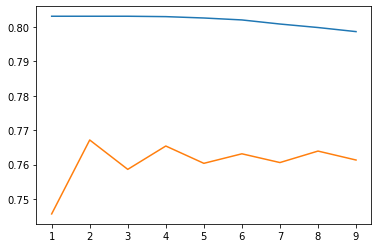

In [41]:
accuracy_end,modello,titolo,X_train,X_test = con_senza_fselection(X_train,y_train,X_test,y_test)

model

L'ACCURACY FINALE SCELTA È CON : DT CON UN ACCURACY DEL 80.3 %


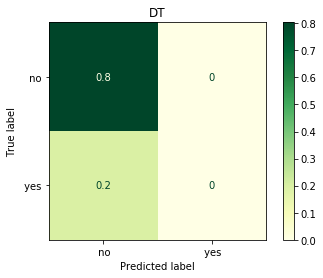

In [42]:
print("L'ACCURACY FINALE SCELTA È CON :",titolo,"CON UN ACCURACY DEL {0:.{1}f}".format(accuracy_end*100, 1),"%")
da_plottare(modello,X_train,y_train,X_test,y_test,titolo)

In [43]:
!pip freeze > requirements_training.txt